# EASC 305: Spatial Analysis (Part 2)  
---
# Geostatistics: variograms 

In [1]:
%matplotlib notebook 

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font',   size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes',   titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Demo 1: Experimental variograms

In [2]:
# x,y,z triplets
data = sio.loadmat('geost_dat.mat')
x    = data['x'][0:140].astype(np.float)
y    = data['y'][0:140].astype(np.float)
z    = data['z'][0:140].astype(np.float)

Plot data locations in $x$ and $y$, and inspect $z$ distribution  

<IPython.core.display.Javascript object>


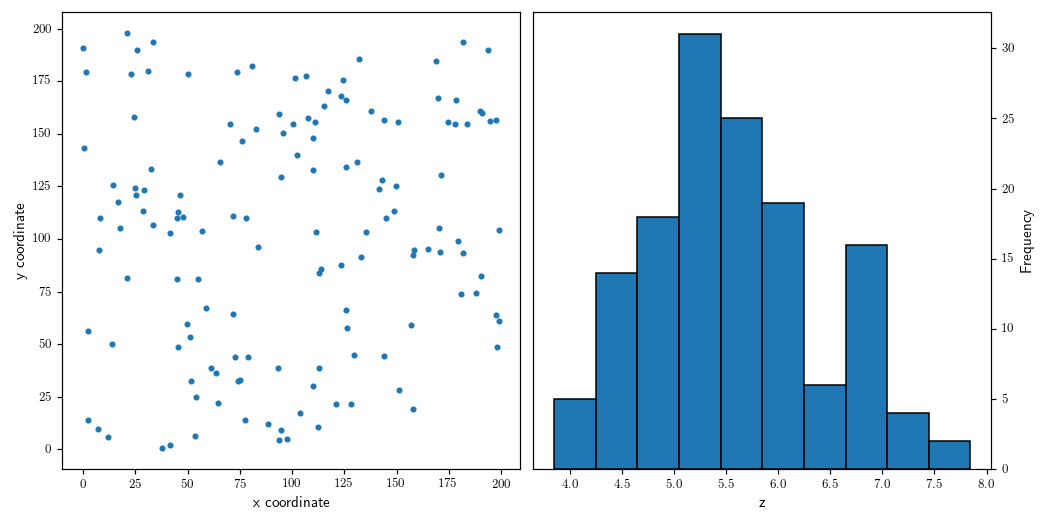

In [3]:
fig, ax = plt.subplots(1,2,figsize=(9.6,4.8))

ax[0].scatter(x,y,marker='.')
ax[0].set_ylabel('y coordinate')
ax[0].set_xlabel('x coordinate')

_ = ax[1].hist(z,edgecolor='k')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('z')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

fig.tight_layout();

## Create Data Pairs

In [4]:
# Construct arrays that include all combinations of data pairs
X1, X2 = np.meshgrid(x,x)
Y1, Y2 = np.meshgrid(y,y)
Z1, Z2 = np.meshgrid(z,z)

To better understand what we are going to do, let's first create a simpler array `V` and visualize it:

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

[[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]]

[[0. 1. 2. 3.]
 [1. 0. 1. 2.]
 [2. 1. 0. 1.]
 [3. 2. 1. 0.]]


<IPython.core.display.Javascript object>


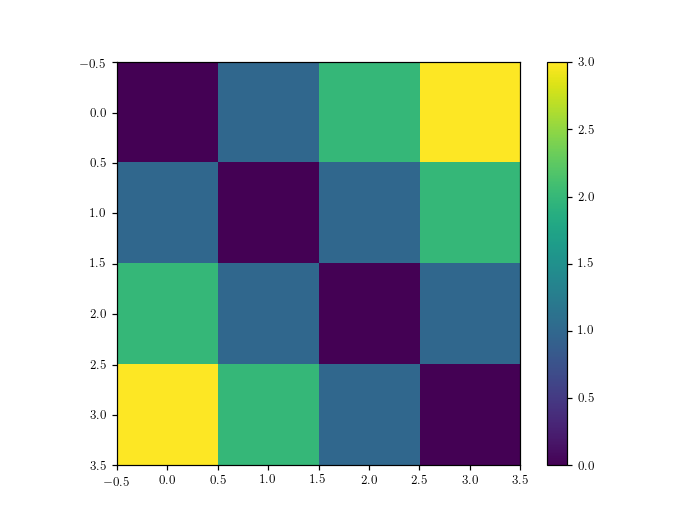

In [5]:
V = np.array([1,2,3,4])
V1, V2 = np.meshgrid(V,V)

print(V1)
print('')
print(V2)
print('')
print(np.sqrt((V1-V2)**2))

fig, ax = plt.subplots(1,1)
im = ax.imshow(np.sqrt((V1-V2)**2))
fig.colorbar(im,ax=ax);

## Compute separation distances ("lags") between all pairs:

In [6]:
D = np.sqrt( (X1-X2)**2 + (Y1-Y2)**2)

<IPython.core.display.Javascript object>


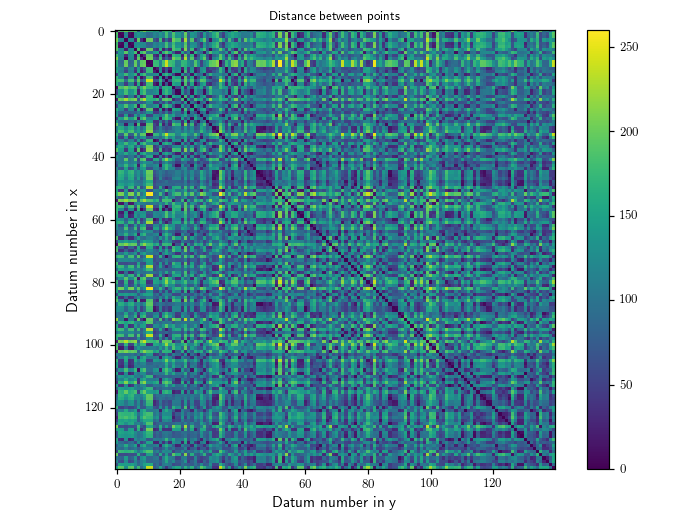

In [7]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(D)
ax.set_ylabel('Datum number in x')
ax.set_xlabel('Datum number in y')
ax.set_title('Distance between points')
fig.colorbar(im,ax=ax)

fig.tight_layout();

## Compute semivariance for each data pair (this counts each pair twice):

Semivariance between two points separated by lag $h$:
\begin{align*}
\gamma_i(h) = \frac{1}{2} \left( z_{x_i} - z_{x_{i+h}}\right)^2
\end{align*}


In [8]:
G = (1/2.) * (Z1 - Z2)**2

<IPython.core.display.Javascript object>


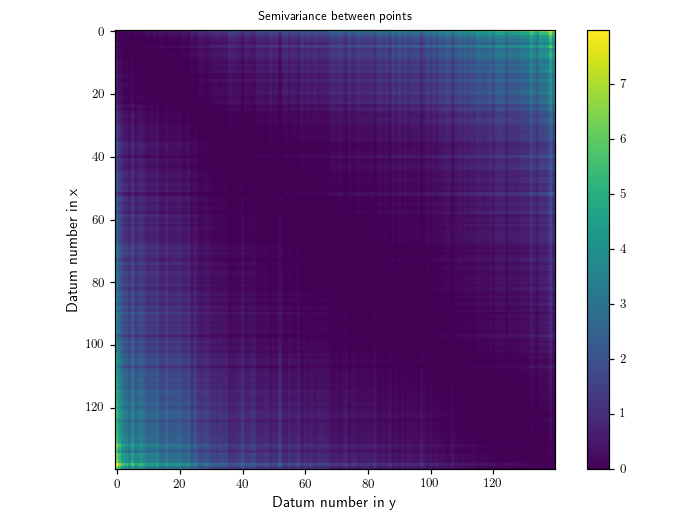

In [9]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(G)
ax.set_ylabel('Datum number in x')
ax.set_xlabel('Datum number in y')
ax.set_title('Semivariance between points')
fig.colorbar(im,ax=ax)

fig.tight_layout();

## Define minimum and maximum lags for irregularly spaced data

Min lag: mean min distance of points. Assign diagonal of D to value of NaN (to remove zeros)  

In [10]:
D2  = D + D*np.diag((x*np.nan)[:,0])
# find mean of the min of each column
lag = np.nanmin(D2, axis=0).mean()
print(lag)

8.275778382148426


Max lag: half max distance between points

In [11]:
hmd      = np.max(D)/2         # Find max distance between points/2
max_lags = np.floor(hmd/lag)   # Calculate a number of lags

print(hmd)
print(max_lags)

130.05564626343602
15.0


##  Bin calculated distances as integers according to lag  

In [12]:
all_lags = np.ceil(D/lag)

#fig, ax = plt.subplots(1,1)
#im = ax.imshow(all_lags)
#ax.set_ylabel('Datum number in x')
#ax.set_xlabel('Datum number in y')
#ax.set_title('Distance between points')
#fig.colorbar(im,ax=ax)
#fig.tight_layout();

In [13]:
mean_lag  = np.zeros(int(max_lags))
num_pairs = np.zeros(int(max_lags))
vario     = np.zeros(int(max_lags))

for i in range(int(max_lags)):
    selection    = all_lags == (i+1)                 # select points in bin (1 = true)
    mean_lag[i]  = np.mean(D[selection])             # compute mean lag
    num_pairs[i] = np.sum(selection.astype(int))/ 2  # count pairs
    vario[i]     = np.mean(G[selection])             # populate variogram
    
# Compute variance of original data
varz = np.var(z)

## Plot semivariogram and variance of data

<IPython.core.display.Javascript object>


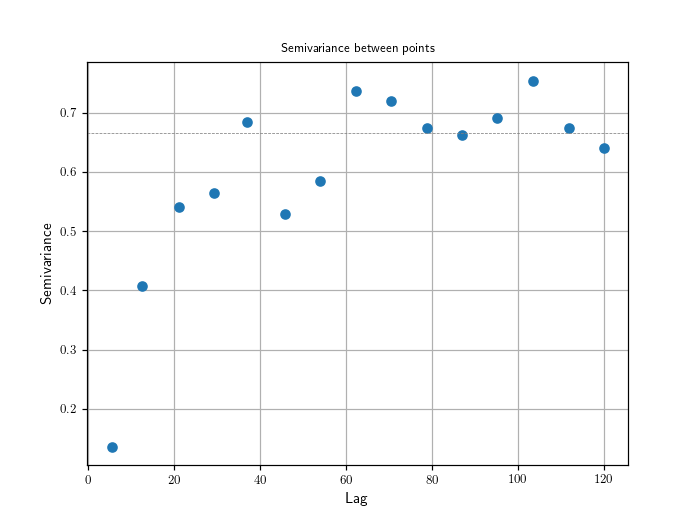

Text(0.5, 1.0, 'Semivariance between points')

In [14]:
fig, ax = plt.subplots(1,1)

ax.plot(mean_lag,vario,'o')
ax.axhline(varz, ls='--', c='grey', lw = 0.5)
ax.grid()
ax.set_ylabel('Semivariance')
ax.set_xlabel('Lag')
ax.set_title('Semivariance between points')


# Demo 2: Fitting experimental variograms with models

In [15]:
# Create lag vector for models that extends to max experimental lag
lags = np.arange(0,np.ceil(mean_lag.max()))

__Spherical model with optional nugget:__

\begin{align*}
 \gamma_{\rm h} = 
 \begin{cases}
        \sigma^2_0 \left( \frac{3h}{2a} - \frac{h^3}{2a^3} \right), & \text{for } h<a\\
        \sigma^2_0, & \text{for } h>a
 \end{cases}
\end{align*}

Model is polynomial in $h$; can be fit to data by regression methods.

In [16]:
nugget = 0 
sill   = varz
range = 40

mod_sphere = nugget + \
             sill*((3*lags)/(2*range) - lags**3/(2*range**3))*(lags <= range) + \
             sill*(lags > range)

In [17]:
varz

0.6671990525459671

__Linear Model with nugget:__

\begin{align*}
 \gamma_{\rm h} = 
 \begin{cases}
        \alpha h    & \text{for } h<a\\
        \sigma^2_0, & \text{for } h>a
 \end{cases}
\end{align*}

Sharp break inserted at range to prevent model from increasing without bound.

In [18]:
nugget = 0.05
slope  = 0.02

mod_lin = (nugget + slope*lags) * (nugget + slope*lags < varz) + \
          varz*(nugget + slope*lags >= varz)

__Exponential Model with nugget:__

\begin{align*}
 \gamma_{\rm h} = \sigma^2_0 \left( 1 - e^{-\frac{3h}{a}} \right)
\end{align*}

Asymptotically approaches sill.

In [19]:
nugget = 0.02
sill   = varz
range  = 45
  
mod_exp = nugget + sill*(1 - np.exp(-3*lags/range))

<IPython.core.display.Javascript object>


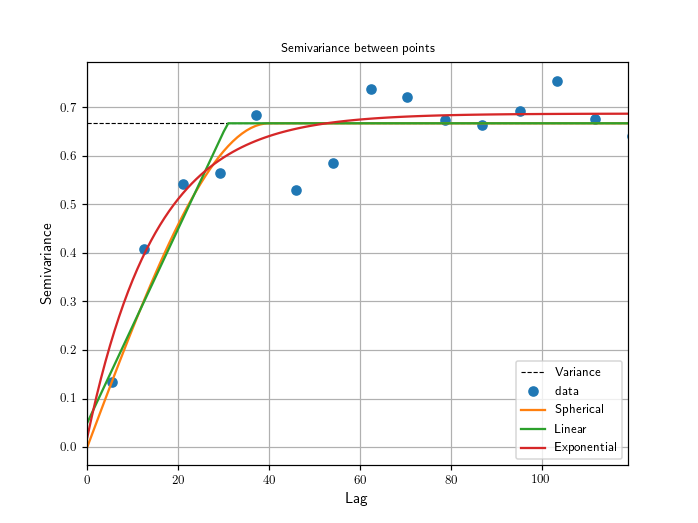

In [20]:
fig, ax = plt.subplots(1,1)

ax.plot(lags,varz*np.ones_like(lags),  ls='--', c='k', lw = 0.75, label='Variance')
ax.plot(mean_lag,vario,'o', label='data')
ax.plot(lags,mod_sphere,label='Spherical')
ax.plot(lags,mod_lin, label='Linear')
ax.plot(lags,mod_exp, label='Exponential')
ax.legend()

ax.set_xlim(lags[0],lags[-1])
ax.grid()
ax.set_ylabel('Semivariance')
ax.set_xlabel('Lag')
ax.set_title('Semivariance between points');